In [1]:
import ensaio
import pandas as pd
import verde as vd
import numpy as np
fname = ensaio.fetch_southern_africa_gravity(version=1)
data = pd.read_csv(fname)
data

,longitude,latitude,height_sea_level_m,gravity_mgal
0,18.34444,-34.12971,32.2,979656.12
1,18.36028,-34.08833,592.5,979508.21
2,18.37418,-34.19583,18.4,979666.46
3,18.40388,-34.23972,25.0,979671.03
4,18.41112,-34.16444,228.7,979616.11
...,...,...,...,...
14354,21.22500,-17.95833,1053.1,978182.09
14355,21.27500,-17.98333,1033.3,978183.09
14356,21.70833,-17.99166,1041.8,978182.69
14357,21.85000,-17.95833,1033.3,978193.18


In [14]:
fname

WindowsPath('C:/Users/00103168/AppData/Local/ensaio/ensaio/Cache/v1/southern-africa-gravity.csv.xz')

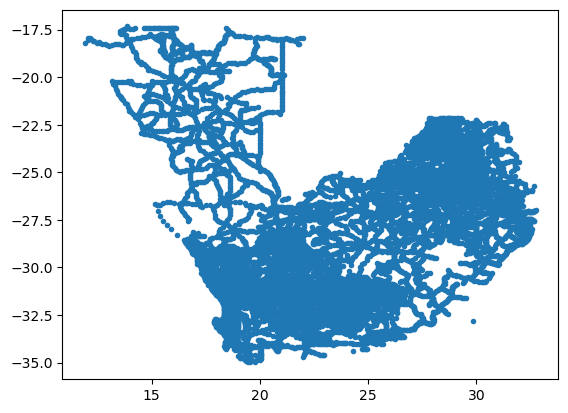

In [13]:
plt.plot(data.longitude,data.latitude,'.')

In [2]:
import boule as bl

normal_gravity = bl.WGS84.normal_gravity(data.latitude, data.height_sea_level_m)
disturbance = data.gravity_mgal - normal_gravity

In [3]:
import pyproj

projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
easting, northing = projection(data.longitude.values, data.latitude.values)
coordinates = (easting, northing, data.height_sea_level_m)

In [4]:
import harmonica as hm

eqs = hm.EquivalentSourcesGB(
    depth=9e3, damping=10, block_size=2e3, window_size=100e3, random_state=42
)

In [5]:
eqs.estimate_required_memory(coordinates)

1210568

In [6]:
np.int64(1210568)

1210568

In [7]:
eqs.fit(coordinates, disturbance)

EquivalentSourcesGB(block_size=2000.0, damping=10, depth=9000.0,
                    random_state=42, window_size=100000.0)

In [11]:
import ipywidgets as widgets
import matplotlib.pyplot as plt

# Define a function to update the grid and plot based on extra_coords value
def update_plot(extra_coords):
    # Generate grid coordinates based on the selected value of extra_coords
    grid_coords = vd.grid_coordinates(
        region=vd.get_region(coordinates),
        spacing=5e3,
        extra_coords=extra_coords,
    )
    # Create the grid with the magnetic anomaly data
    grid = eqs.grid(grid_coords, data_names=["gravity_amonaly"])
    
    # Plotting the grid using matplotlib
    plt.figure(figsize=(10, 6))
    plt.imshow(
        grid["gravity_amonaly"].values,
        extent=(grid.coords["easting"].min(), grid.coords["easting"].max(), 
                grid.coords["northing"].min(), grid.coords["northing"].max()),
        origin="lower"
    )
    plt.colorbar(label="Gravity Anomaly (mGal)")
    plt.title(f"Observational Height (km) = {extra_coords/1e3}")
    plt.xlabel("Easting")
    plt.ylabel("Northing")
    plt.show()

# Create an interactive widget for controlling extra_coords
extra_coords_slider = widgets.IntSlider(
    value=2.5e3,
    min=2.5e3,
    max=100e3,
    step=1e3,
    description='Height (m):',
    continuous_update=False
)

# Link the widget to the update function
widgets.interactive(update_plot, extra_coords=extra_coords_slider)


interactive(children=(IntSlider(value=2500, continuous_update=False, description='Height (m):', max=100000, mi…